<a href="https://colab.research.google.com/github/biki321/Sentiments-analysis-on-tweets/blob/master/analytic_vidya_sentiments_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !pip install contractions
# !pip install wordcloud

In [45]:
import re, string, unicodedata
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
#warnings.filterwarnings("ignore", category=DeprecationWarning
import contractions
import inflect
import nltk
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import f1_score

%matplotlib inline

In [7]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
path_to_train_data = '/content/drive/My Drive/NLP/analytic_vidya_sentimens_pratice/train_2kmZucJ.csv'
path_to_test_data = '/content/drive/My Drive/NLP/analytic_vidya_sentimens_pratice/test_oJQbWVk.csv'

train = pd.read_csv(path_to_train_data)
test = pd.read_csv(path_to_test_data)

train_original = train.copy()
test_original = test.copy()

In [9]:
print('train data')
print(train_original.head())

print('     ')

print('test data')
print(test_original.head())

train data
   id  label                                              tweet
0   1      0  #fingerprint #Pregnancy Test https://goo.gl/h1...
1   2      0  Finally a transparant silicon case ^^ Thanks t...
2   3      0  We love this! Would you go? #talk #makememorie...
3   4      0  I'm wired I know I'm George I was made that wa...
4   5      1  What amazing service! Apple won't even talk to...
     
test data
     id                                              tweet
0  7921  I hate the new #iphone upgrade. Won't let me d...
1  7922  currently shitting my fucking pants. #apple #i...
2  7923  I'd like to puts some CD-ROMS on my iPad, is t...
3  7924  My ipod is officially dead. I lost all my pict...
4  7925  Been fighting iTunes all night! I only want th...


In [10]:
# train and test data getting combined
combine = train_original.append(test_original,  ignore_index=True, sort=False)
combine.tail()

,id,label,tweet
9868,9869,NaN,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old..."
9869,9870,NaN,Now Available - Hoodie. Check it out here - ht...
9870,9871,NaN,There goes a crack right across the screen. If...
9871,9872,NaN,@codeofinterest as i said #Adobe big time we m...
9872,9873,NaN,Finally I got it .. thanx my father .. #Samsun...


In [11]:
#this is used to remove the tweeter handle names
def remove_pattern(text,pattern):    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

#used to reolace contraction.
#eg. 'isn't' is replaced by 'is not'
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)  

In [12]:
#remvoing the @name 
combine['clean_tweet'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")

#replace_contractions
combine['clean_tweet'] = combine['clean_tweet'].apply( lambda x: replace_contractions(x) )
print(combine['clean_tweet'])

0       #fingerprint #Pregnancy Test https://goo.gl/h1...
1       Finally a transparant silicon case ^^ Thanks t...
2       We love this! Would you go? #talk #makememorie...
3       I am wired I know I am George I was made that ...
4       What amazing service! Apple will not even talk...
                              ...                        
9868    #SamsungGalaxyNote7 Explodes, Burns 6-Year-Old...
9869    Now Available - Hoodie. Check it out here - ht...
9870    There goes a crack right across the screen. If...
9871     as i said #Adobe big time we may well as incl...
9872    Finally I got it .. thanx my father .. #Samsun...
Name: clean_tweet, Length: 9873, dtype: object


In [13]:
#tokenization
#means spliting the sentences into words in this case
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
combine['clean_tweet'] = combine['clean_tweet'].apply( lambda x: tknzr.tokenize(x) )
print(combine['clean_tweet'])

0       [#fingerprint, #Pregnancy, Test, https://goo.g...
1       [Finally, a, transparant, silicon, case, ^, ^,...
2       [We, love, this, !, Would, you, go, ?, #talk, ...
3       [I, am, wired, I, know, I, am, George, I, was,...
4       [What, amazing, service, !, Apple, will, not, ...
                              ...                        
9868    [#SamsungGalaxyNote7, Explodes, ,, Burns, 6, -...
9869    [Now, Available, -, Hoodie, ., Check, it, out,...
9870    [There, goes, a, crack, right, across, the, sc...
9871    [as, i, said, #Adobe, big, time, we, may, well...
9872    [Finally, I, got, it, .., thanx, my, father, ....
Name: clean_tweet, Length: 9873, dtype: object


In [16]:
#these functions are used for data cleaning and normalization
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s\d#]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words


In [17]:
#normalizing the tokens
combine['clean_tweet'] = combine['clean_tweet'].apply( lambda x : normalize(x) )
print(combine['clean_tweet'])

0       [#fingerprint, #pregnancy, test, httpsgooglh1m...
1       [finally, transparant, silicon, case, thank, u...
2       [love, would, go, #talk, #makememories, #unplu...
3       [wire, know, george, make, way, #iphone, #cute...
4       [amaze, service, apple, even, talk, question, ...
                              ...                        
9868    [#samsunggalaxynote7, explode, burn, 6, yearol...
9869    [available, hoodie, check, httpzetasuppliescou...
9870    [go, crack, right, across, screen, could, actu...
9871    [say, #adobe, big, time, may, well, include, #...
9872    [finally, get, thanx, father, #samsung, #galax...
Name: clean_tweet, Length: 9873, dtype: object


In [18]:
#stitch the tokens back together
combine['clean_tweet'] = combine['clean_tweet'].apply( lambda x: ' '.join(x) )
print(combine['clean_tweet'])

0       #fingerprint #pregnancy test httpsgooglh1mfqv ...
1       finally transparant silicon case thank uncle #...
2       love would go #talk #makememories #unplug #rel...
3       wire know george make way #iphone #cute #daven...
4       amaze service apple even talk question unless ...
                              ...                        
9868    #samsunggalaxynote7 explode burn 6 yearold tha...
9869    available hoodie check httpzetasuppliescoukpro...
9870    go crack right across screen could actually pr...
9871          say #adobe big time may well include #apple
9872    finally get thanx father #samsung #galaxy #s3 ...
Name: clean_tweet, Length: 9873, dtype: object


In [19]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

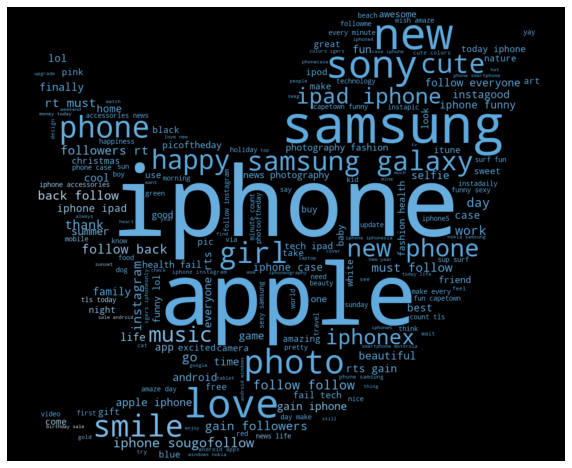

In [21]:
#generating wordcloud visualization for positive words
all_positive_words = ' '.join(text for text in combine['clean_tweet'][combine['label']==0] )

Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_positive_words)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

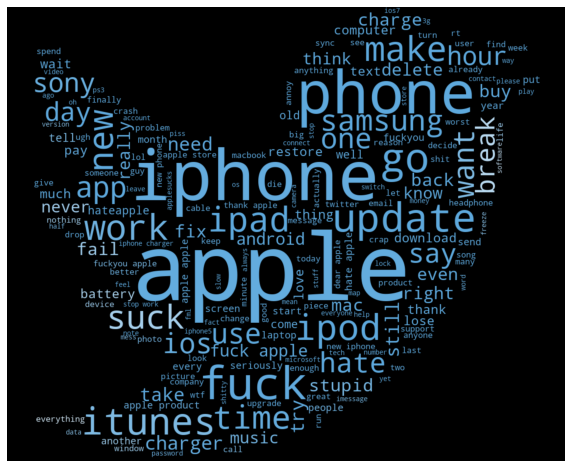

In [22]:
#generating wordcloud visualization for negative words
all_negative_words = ' '.join(text for text in combine['clean_tweet'][combine['label']==1] )

Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_negative_words)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

In [23]:
#analysing hashtags

def Hashtags_Extract(x):
    hashtags=[]
    
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags 
    
ht_positive = Hashtags_Extract( combine['clean_tweet'][combine['label']==0] )
ht_positive = sum(ht_positive, [])

ht_negative = Hashtags_Extract( combine['clean_tweet'][combine['label']==1] )
ht_negative = sum(ht_negative, [])


In [24]:
word_freq_positive = nltk.FreqDist(ht_positive)
word_freq_negative = nltk.FreqDist(ht_negative)
word_freq_positive

FreqDist({'fingerprint': 4,
          'pregnancy': 1,
          'android': 331,
          'apps': 106,
          'beautiful': 205,
          'cute': 297,
          'health': 116,
          'igers': 144,
          'iphoneonly': 132,
          'iphonesia': 137,
          'iphone': 2831,
          'yay': 34,
          'sony': 720,
          'xperia': 48,
          'sonyexperias': 1,
          'talk': 3,
          'makememories': 1,
          'unplug': 1,
          'relax': 29,
          'smartphone': 99,
          'wifi': 16,
          'connect': 1,
          'daventry': 1,
          'home': 71,
          'instapic': 56,
          'instadaily': 73,
          'us': 6,
          'xperiaz': 8,
          'uk': 20,
          'bay': 1,
          'amazon': 49,
          'etsy': 4,
          'rob': 1,
          'toby': 2,
          'evemun': 1,
          'mcmafia': 1,
          'taylor': 2,
          'spectre': 1,
          'newyear': 42,
          'starting': 1,
          'recipes': 1,
         

In [25]:
df_positive = pd.DataFrame({'Hashtags':list(word_freq_positive.keys()),'Count':list(word_freq_positive.values())})
df_negative = pd.DataFrame({'Hashtags':list(word_freq_negative.keys()),'Count':list(word_freq_negative.values())})
df_positive.head(10)

,Hashtags,Count
0,fingerprint,4
1,pregnancy,1
2,android,331
3,apps,106
4,beautiful,205
5,cute,297
6,health,116
7,igers,144
8,iphoneonly,132
9,iphonesia,137


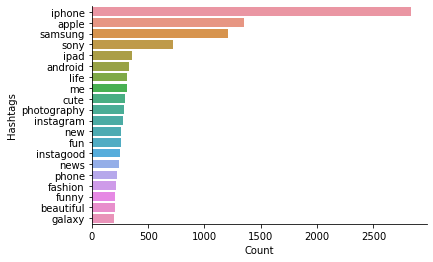

In [26]:
#it is consist of the 20 most frequent hashtags
df_positive_plot = df_positive.nlargest(20,columns='Count')

sns.barplot(data=df_positive_plot,y='Hashtags',x='Count')
sns.despine()

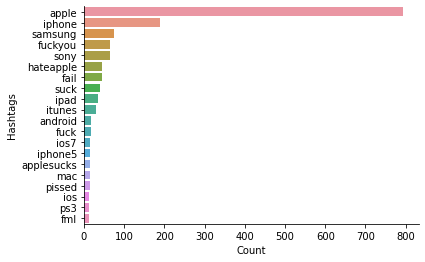

In [27]:
#it consist of 20 most frequent hashtags
df_negative_plot = df_negative.nlargest(20,columns='Count')

sns.barplot(data=df_negative_plot,y='Hashtags',x='Count')
sns.despine()

In [31]:
# building the bagofword
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combine['clean_tweet'])

df_bow = pd.DataFrame(bow.todense())
df_bow.shape

(9873, 6485)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')

tfidf_matrix=tfidf.fit_transform(combine['clean_tweet'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf.shape

(9873, 6485)

In [43]:
#spilting into training set(separating the labeled and unlabeled data)
train_bow = bow[:7920]
train_bow.todense()

train_tfidf_matrix = tfidf_matrix[:7920]
train_tfidf_matrix.todense()

21974.13323180549

In [44]:
#Splitting the data into training and validation set
from sklearn.model_selection import train_test_split

x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,train['label'],test_size=0.3,random_state=2)
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,train['label'],test_size=0.3,random_state=17)


In [48]:
#initializing a logistic regression
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')


In [49]:
#fit the logistic regression model extracted features by bag of word 
Log_Reg.fit(x_train_bow,y_train_bow)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
#prediction using logistics regression(bag of words is used for features extracation)
prediction_bow = Log_Reg.predict_proba(x_valid_bow)

prediction_bow

array([[0.98820822, 0.01179178],
       [0.13902576, 0.86097424],
       [0.7294263 , 0.2705737 ],
       ...,
       [0.99640155, 0.00359845],
       [0.05425009, 0.94574991],
       [0.96432694, 0.03567306]])

In [56]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_bow[:,1]>=0.3

# converting the results to integer type
prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score 
log_bow = f1_score(y_valid_bow, prediction_int)

log_bow

0.7831236121391562

In [57]:
#Fitting the Logistic Regression Model{tf-idf}
Log_Reg.fit(x_train_tfidf,y_train_tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

prediction_tfidf

array([[0.74620342, 0.25379658],
       [0.71481953, 0.28518047],
       [0.6592601 , 0.3407399 ],
       ...,
       [0.92377546, 0.07622454],
       [0.95465442, 0.04534558],
       [0.85018537, 0.14981463]])

In [59]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_valid_tfidf, prediction_int)

log_tfidf

0.7923664122137404

In [61]:
#The next model we use is XGBoost.
#here first BOW is used for feature extration
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=22,learning_rate=0.9)

model_bow.fit(x_train_bow, y_train_bow)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [62]:
xgb = model_bow.predict_proba(x_valid_bow)

xgb

array([[0.9882697 , 0.01173034],
       [0.02206481, 0.9779352 ],
       [0.8619344 , 0.1380656 ],
       ...,
       [0.99128747, 0.00871252],
       [0.01866955, 0.98133045],
       [0.8882764 , 0.11172362]], dtype=float32)

In [63]:
#calculating f1 for xgboost( bag of words is used)
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
xgb=xgb[:,1]>=0.3

# converting the results to integer type
xgb_int=xgb.astype(np.int)

# calculating f1 score
xgb_bow=f1_score(y_valid_bow,xgb_int)

xgb_bow

0.7538349159970781

In [64]:
#TF-IDF is used for feature extraction
model_tfidf = XGBClassifier(random_state=29,learning_rate=0.7)
model_tfidf.fit(x_train_tfidf, y_train_tfidf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.7, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=29,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [65]:
xgb_tfidf=model_tfidf.predict_proba(x_valid_tfidf)

xgb_tfidf

array([[0.7973553 , 0.20264472],
       [0.5344955 , 0.46550456],
       [0.56728446, 0.4327155 ],
       ...,
       [0.9817977 , 0.01820229],
       [0.98005795, 0.01994203],
       [0.9115635 , 0.08843651]], dtype=float32)

In [66]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
xgb_tfidf=xgb_tfidf[:,1]>=0.3

# converting the results to integer type
xgb_int_tfidf=xgb_tfidf.astype(np.int)

# calculating f1 score
score=f1_score(y_valid_tfidf,xgb_int_tfidf)

score

0.7486712224753227

In [68]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy', random_state=1)

# first BOW is used for featured extraction
dct.fit(x_train_bow,y_train_bow)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [71]:

dct_bow = dct.predict_proba(x_valid_bow)

dct_bow

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [72]:
#calculating f1 score
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dct_bow=dct_bow[:,1]>=0.3

# converting the results to integer type
dct_int_bow=dct_bow.astype(np.int)

# calculating f1 score
dct_score_bow=f1_score(y_valid_bow,dct_int_bow)

dct_score_bow

0.6700167504187605

In [73]:
#TF-IDF features
dct.fit(x_train_tfidf,y_train_tfidf)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [74]:
dct_tfidf = dct.predict_proba(x_valid_tfidf)

dct_tfidf

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [75]:

#calculating f1 scores
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dct_tfidf=dct_tfidf[:,1]>=0.3

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_valid_tfidf,dct_int_tfidf)

dct_score_tfidf

0.6199460916442049

In [76]:
#MODEL COMPARISION 
#BOW 

Algo_1 = ['LogisticRegression(Bag-of-Words)','XGBoost(Bag-of-Words)','DecisionTree(Bag-of-Words)']

score_1 = [log_bow,xgb_bow,dct_score_bow]

compare_1 = pd.DataFrame({'Model':Algo_1,'F1_Score':score_1},index=[i for i in range(1,4)])

compare_1.T

,1,2,3
Model,LogisticRegression(Bag-of-Words),XGBoost(Bag-of-Words),DecisionTree(Bag-of-Words)
F1_Score,0.783124,0.753835,0.670017


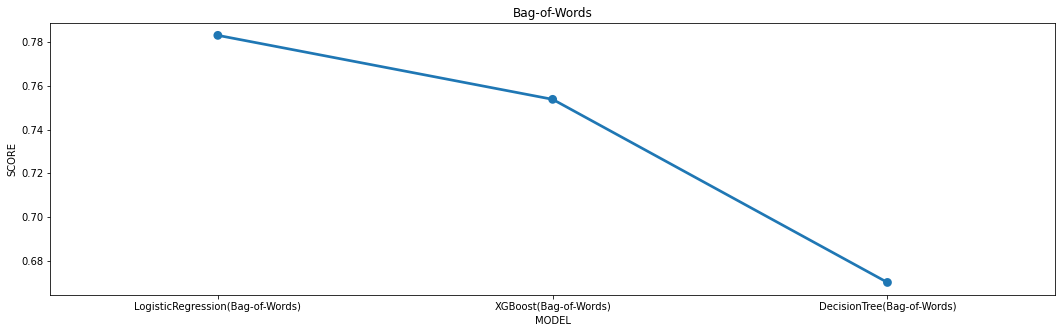

In [77]:
#graph for comaprision
plt.figure(figsize=(18,5))
sns.pointplot(x='Model',y='F1_Score',data=compare_1)

plt.title('Bag-of-Words')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

In [78]:
#TF-IDF
Algo_2 = ['LogisticRegression(TF-IDF)','XGBoost(TF-IDF)','DecisionTree(TF-IDF)']

score_2 = [log_tfidf,score,dct_score_tfidf]

compare_2 = pd.DataFrame({'Model':Algo_2,'F1_Score':score_2},index=[i for i in range(1,4)])

compare_2.T

,1,2,3
Model,LogisticRegression(TF-IDF),XGBoost(TF-IDF),DecisionTree(TF-IDF)
F1_Score,0.792366,0.748671,0.619946


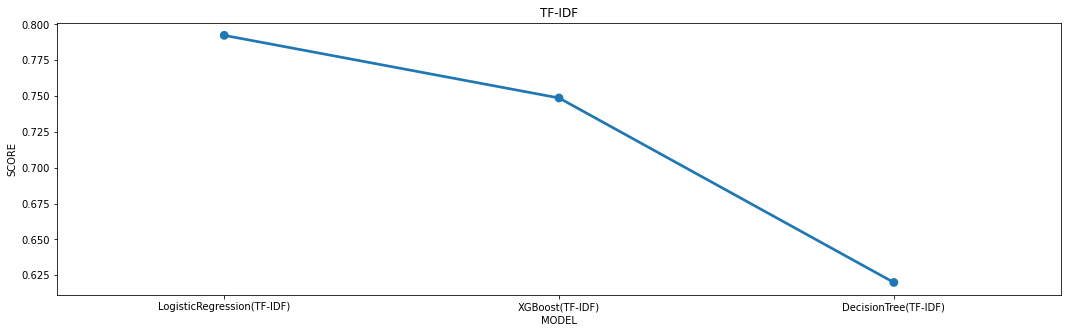

In [79]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare_2)

plt.title('TF-IDF')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

In [80]:
#we have found out that logistics regression scores the best among others models
#so now that logistics regression's performance is compared for both BOW and TF-IDF

Algo_best = ['LogisticRegression(Bag-of-Words)','LogisticRegression(TF-IDF)']

score_best = [log_bow,log_tfidf]

compare_best = pd.DataFrame({'Model':Algo_best,'F1_Score':score_best},index=[i for i in range(1,3)])

compare_best.T

,1,2
Model,LogisticRegression(Bag-of-Words),LogisticRegression(TF-IDF)
F1_Score,0.783124,0.792366


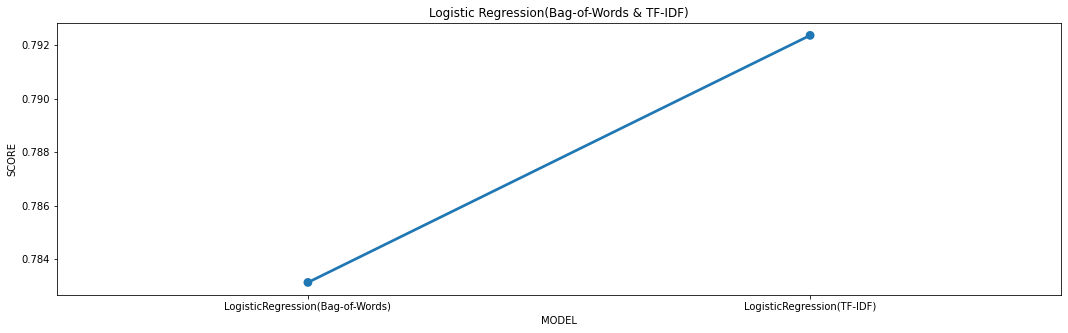

In [81]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare_best)

plt.title('Logistic Regression(Bag-of-Words & TF-IDF)')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

In [83]:
# NOW IT IS TESTING TIME
test_tfidf = tfidf_matrix[7920:]
test_pred = Log_Reg.predict_proba(test_tfidf)

test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

test['label'] = test_pred_int

#submission = test[['id','label']]
test


,id,tweet,label
0,7921,I hate the new #iphone upgrade. Won't let me d...,1
1,7922,currently shitting my fucking pants. #apple #i...,1
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t...",1
3,7924,My ipod is officially dead. I lost all my pict...,1
4,7925,Been fighting iTunes all night! I only want th...,1
...,...,...,...
1948,9869,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old...",0
1949,9870,Now Available - Hoodie. Check it out here - ht...,0
1950,9871,There goes a crack right across the screen. If...,1
1951,9872,@codeofinterest as i said #Adobe big time we m...,1
